In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

In [167]:
data = pd.read_csv("p2-arbres-fr.csv", sep=";")
data.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [168]:
print(data.shape)
print(data.dtypes)
data.isna().mean()

(200137, 18)
id                       int64
type_emplacement        object
domanialite             object
arrondissement          object
complement_addresse     object
numero                 float64
lieu                    object
id_emplacement          object
libelle_francais        object
genre                   object
espece                  object
variete                 object
circonference_cm         int64
hauteur_m                int64
stade_developpement     object
remarquable            float64
geo_point_2d_a         float64
geo_point_2d_b         float64
dtype: object


id                     0.000000
type_emplacement       0.000000
domanialite            0.000005
arrondissement         0.000000
complement_addresse    0.845596
numero                 1.000000
lieu                   0.000000
id_emplacement         0.000000
libelle_francais       0.007480
genre                  0.000080
espece                 0.008754
variete                0.816241
circonference_cm       0.000000
hauteur_m              0.000000
stade_developpement    0.335795
remarquable            0.315274
geo_point_2d_a         0.000000
geo_point_2d_b         0.000000
dtype: float64

In [169]:
data.drop(["complement_addresse", "numero", "variete", "remarquable", "stade_developpement"], axis="columns", inplace=True)

In [170]:
data["type_emplacement"].unique()

array(['Arbre'], dtype=object)

In [171]:
data.drop("type_emplacement", axis="columns", inplace=True)
data.head()

,id,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
0,99874,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,20,5,48.857620,2.320962
1,99875,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,65,8,48.857656,2.321031
2,99876,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,90,10,48.857705,2.321061
3,99877,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,60,8,48.857722,2.321006
4,99878,Jardin,PARIS 17E ARRDT,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,38,0,48.890435,2.315289


In [172]:
data["id"].duplicated().sum()

np.int64(0)

In [173]:
data.describe()

,id,circonference_cm,hauteur_m,geo_point_2d_a,geo_point_2d_b
count,2.001370e+05,200137.000000,200137.000000,200137.000000,200137.000000
mean,3.872027e+05,83.380479,13.110509,48.854491,2.348208
std,5.456032e+05,673.190213,1971.217387,0.030234,0.051220
min,9.987400e+04,0.000000,0.000000,48.742290,2.210241
25%,1.559270e+05,30.000000,5.000000,48.835021,2.307530
50%,2.210780e+05,70.000000,8.000000,48.854162,2.351095
75%,2.741020e+05,115.000000,12.000000,48.876447,2.386838
max,2.024745e+06,250255.000000,881818.000000,48.911485,2.469759


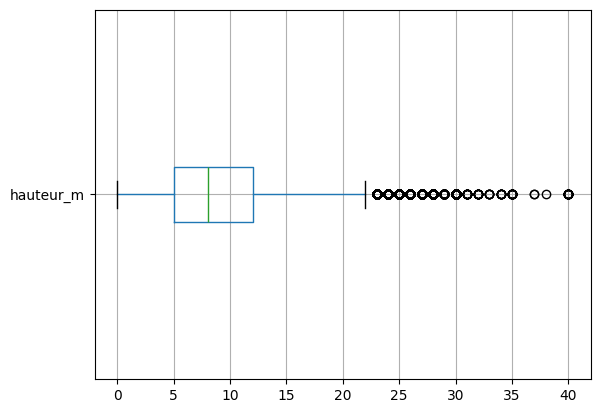

La hauteur moyenne d'un arbre est de 8.33m


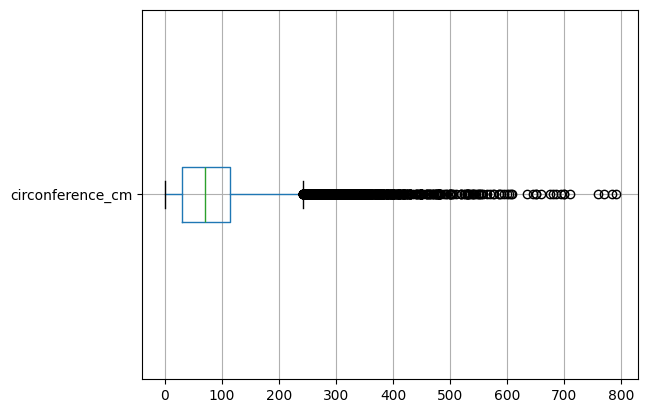

La circonference moyenne d'un arbre est de 79.64cm


In [174]:
data.loc[data["hauteur_m"] > 40, "hauteur_m"] = np.nan
data.loc[data["circonference_cm"] > 800, "circonference_cm"] = np.nan
data.boxplot(column="hauteur_m", vert=False)
plt.show()
print("La hauteur moyenne d'un arbre est de {}m".format(data["hauteur_m"].mean().round(2)))
data.boxplot(column="circonference_cm", vert=False)
plt.show()
print("La circonference moyenne d'un arbre est de {}cm".format(data["circonference_cm"].mean().round(2)))

In [175]:
tree_location_by_zone = data.groupby("arrondissement")[["geo_point_2d_a", "geo_point_2d_b"]].mean()
tree_number_by_location = data.groupby("arrondissement").size()
tree_location_by_zone_list = tree_location_by_zone.values.tolist()
tree_map = folium.Map((data["geo_point_2d_a"].mean(), data["geo_point_2d_b"].mean()), zoom_start=12)
for zone in range(0, len(tree_location_by_zone_list)):
    folium.Marker(tree_location_by_zone_list[zone], popup="{} Arbres".format(tree_number_by_location[zone]), icon=folium.Icon(color="green", icon_color="white", icon="tree", prefix='fa')).add_to(tree_map)
tree_map

C:\Users\barth\AppData\Local\Temp\ipykernel_21400\2424592174.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  folium.Marker(tree_location_by_zone_list[zone], popup="{} Arbres".format(tree_number_by_location[zone]), icon=folium.Icon(color="green", icon_color="white", icon="tree", prefix='fa')).add_to(tree_map)
